In [1]:
import matplotlib.pylab as plt

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.cluster import KMeans as kmeans

In [4]:
from PIL import Image

In [5]:
import numpy as np 

In [6]:
import os, csv

In [28]:
model_image_ = Image.open('model_image.png')
x_range, y_range = 1920, 1080
model_image = model_image_.resize((x_range, y_range), Image.ANTIALIAS)

In [29]:
def load_data(subject_id, day= 1, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)

    for file_name in data_file_names: 
        if str(subject_id) in file_name:    
            if listen: print(file_name, subject_id)
            subject_path = data_path + file_name

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """

    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    xy_time = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US
    fix_info = []
    fix_duration = []
    fix_xy = []
    fix_time = [] 
    
    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
                xy_time.append(np.nan)
            else: 
                xy.append([float(msg[1]), float(msg[2])])
                xy_time.append(float(msg[0]))
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        if space == -1: space = str.find(msg[1], " 0 0 ../")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                
                if msg[0][0:4] == "EFIX":
                    fix_info.append(msg)
                    fix_duration.append(float(msg[2]))
                    fix_xy.append((float(msg[3]),float(msg[4])))
                    fix_time.append(float(msg[0][9:]))
                    
                        
    fixation = {'xy':np.array(fix_xy), 'duration':np.array(fix_duration), 'info':fix_info, 'time':fix_time}
    
    stimuli = {"CS+":np.array(cs_pos), "CS-":np.array(cs_neg), 
               "US":np.array(us_sti), "cs_type":cs_type, "onsets":np.array(onsets)}
    
    data = {"raw_pupil":np.array(_pupil_), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "xy_time":np.array(xy_time), 
            "fixation": fixation, 
            "stimuli": stimuli}
                    

    return data

In [10]:
# data = extract_data(subject_data) ; print('experimental information: ', list(data.keys())) 

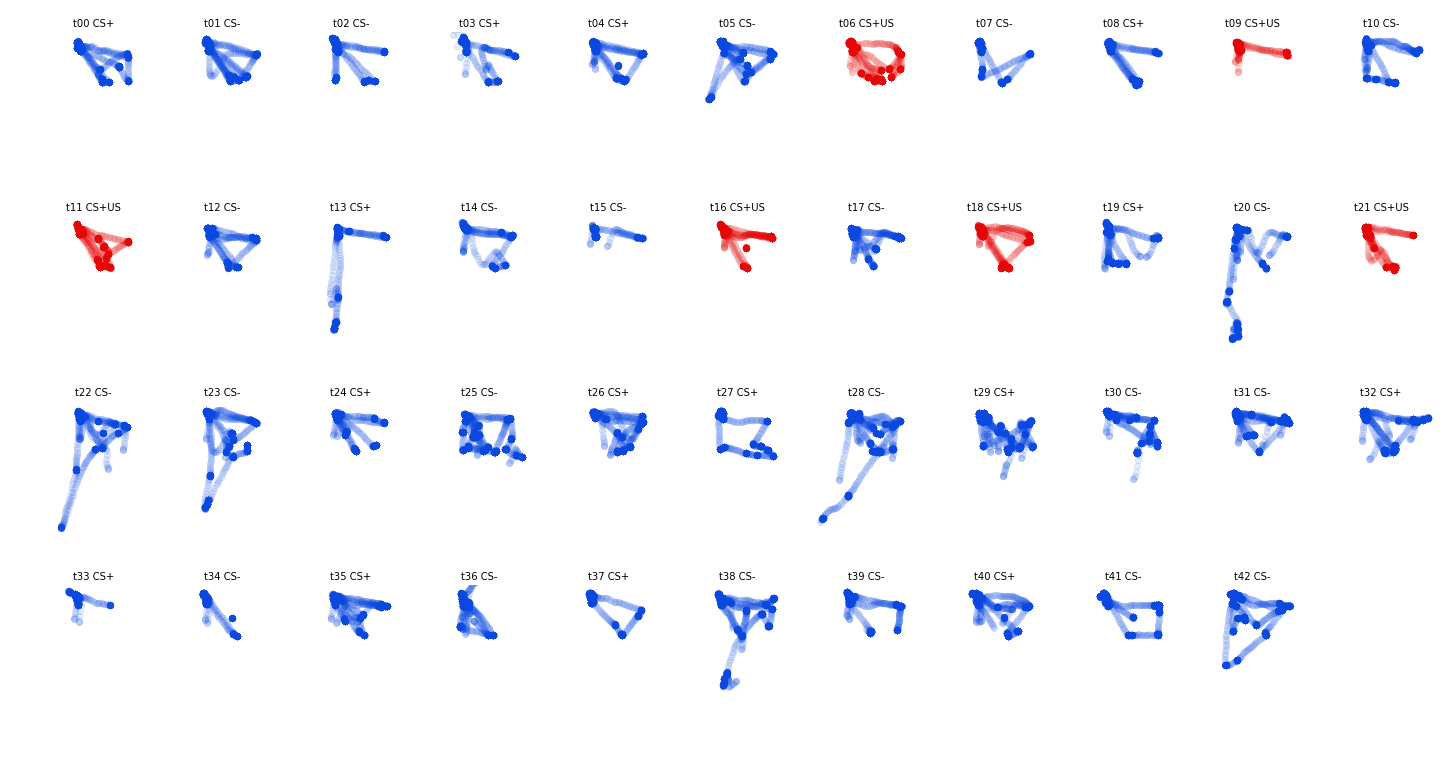

In [30]:
subject_data = load_data('12')
data = extract_data(subject_data)

# interval info
xy = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['stimuli']['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,13]); 
for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.xlim([-500, 2000]) ; 
    plt.ylim([2500, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['stimuli']['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['stimuli']['cs_type'][ii]), fontsize=10)

In [12]:
# load reference image for stimuli
y_len, x_len, _ = np.shape(model_image)

In [16]:
# big_picture = 0

# plt.figure(figsize=[20,8])
# for i_subject in range(len(subjects)):  

#     plt.subplot(1,2,i_subject+1); plt.axis('off')
#     plt.imshow(model_image, alpha=.8)
    
#     subject_data = load_data(subjects[i_subject])
#     data = extract_data(subject_data)
        
#     # need to do some rescaling to format gaze data with arbitrary-size jpeg
#     plt.scatter(data['fixation']['xy'][:,0], data['fixation']['xy'][:,1],marker='o', 
#                 s=data['fixation']['duration'], alpha=.05, c = 'red')
#     plt.title('fixation location and durations across experiment for subject %s\n'%subjects[i_subject]); 

#     if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

```
                          is that lower left shift towards their own hand? 
```

```
                                is there more entropy after conditioning is over?
```


					12's gaze behavior across the experiment


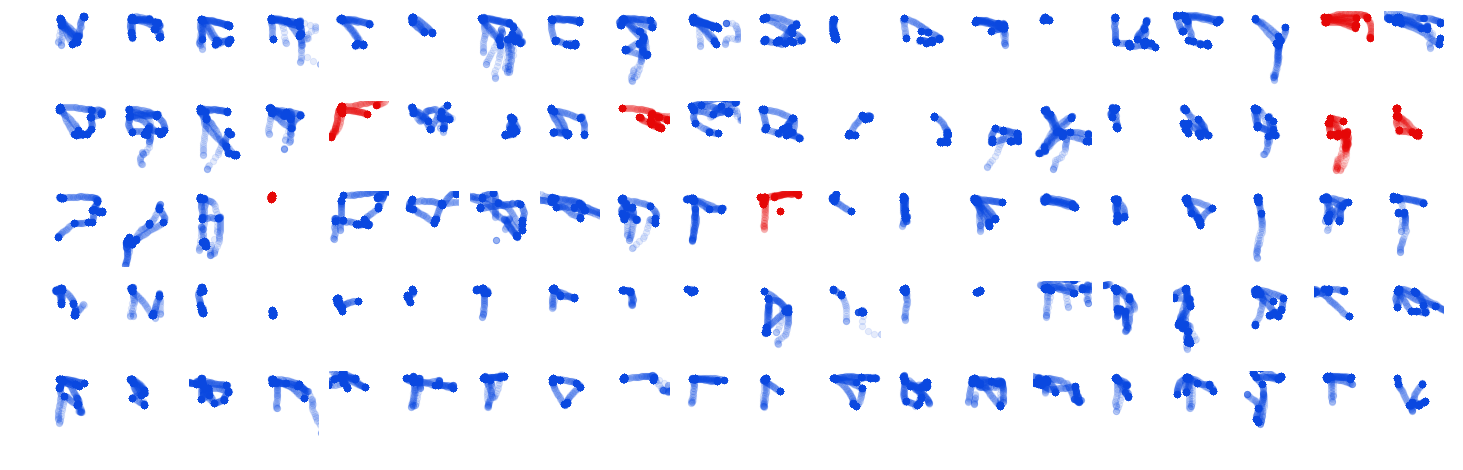

In [17]:
start, end = 0, len(data['xy']) 
step = round((end-start)/100)
show = np.arange(start, end, step)

# define US onsets in experiment
us_onsets = np.nonzero(np.convolve(data['stimuli']['US'], [1,-1]))[0]

def find_color(interval_0, interval_1, us_onsets, color = 'xkcd:blue'):    
    for i_onset in us_onsets: 
        if interval_0 < i_onset < interval_1: color = 'xkcd:red' 
    return color

plt.figure(figsize=[25,8]); 
for ii in range(len(show)-1): 
    
    # aesthetics
    plt.subplot(5,20,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    
    # plot data with US dependent color
    color = find_color(show[ii], show[ii+1], us_onsets)
    plt.scatter(data['xy'][show[ii]:show[ii+1],0],-data['xy'][show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = '%s'%color);

print("\n\t\t\t\t\t12's gaze behavior across the experiment")

> a possible approach: 
> - kmeans clustering (k = 3) on each subjects whole timecourse
> - assuming clusters are in a "reasonable" location
>    - use the total `inertia_` for each subject as a measure of attention -- one covariate
>    - use trial-level `inertia_` as a measure of attention -- or entropy 

In [18]:
def kmeans_coordinates(xy, cut, n_clusters=3): 
   
    if cut: 
        x_range, y_range = 1920, 1080
        x_cut = np.array([0 < xy[ii,0] < x_range for ii in range(len(xy))])
        y_cut = np.array([0 < xy[ii,1] < y_range for ii in range(len(xy))])
        cuts = x_cut & y_cut
        x = np.delete(xy[:,0], np.nonzero(cuts==False))
        y = np.delete(xy[:,1], np.nonzero(cuts==False))
        xy = np.stack((x,y)).T
        

    # ignore nans, flip (?) y axis, fit model
    keep_inds = xy[:,0] == xy[:,0]
    xy = xy[keep_inds]
    
    # correct for inversion depending on image type
    k = kmeans(n_clusters=n_clusters, random_state=0).fit(xy)
    
    return k, xy

In [32]:
def generate_clusters(subjects, show=1, cut=1, big_picture=0): 
    
    cluster_data = {}
    
    # colors, shape
    colors = ['#00ccff', '#ff00ff', '#00ffaa'] #6600ff'] 
    y_len, x_len, _ = np.shape(model_image)
    cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}
    
    if show: plt.figure(figsize=[15, 12])

    for i_subject in range(len(subjects)):
        
        subject_name = subjects[i_subject]

        # get subject's data
        subject_data = load_data(subject_name)
        data = extract_data(subject_data)
        
        # generate clusters
        k, xy = kmeans_coordinates(data['fixation']['xy'], cut)
        
        # save 
        cluster_data['%s'%subject_name] = {'data':data, 'k':k, 'xy':xy}
        
        if show: 
            
            # find data to color mapping
            point_colors = [colors[ii] for ii in k.labels_]
            # setup plot
            plt.subplot(1,2,i_subject+1); plt.axis('off')
            # show background experimental stimuli
            plt.imshow(model_image, alpha=.1)
            # plot gaze data according to cluster color
            plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
            # extract centers of mass for each cluster
            centers = np.round(k.cluster_centers_)

            # plot center of mass for each cluster in a way we can clearly lable in legend
            for i_loc in range(len(centers)):
                plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
                plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                            s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
                plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                             xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

            # control aesthetics
            if not big_picture: 
                plt.xlim([0, x_len]), 
                plt.ylim([y_len, 0])
            plt.legend(); ax = plt.gca(); ax.legend(fontsize = 6+1, loc=3)
            plt.title("\nsubject %s \nexperimental average from centers of mass: %.02f pixels\n" 
                      %(subjects[i_subject], np.sqrt(k.inertia_/len(xy)) ) )

    
    return cluster_data

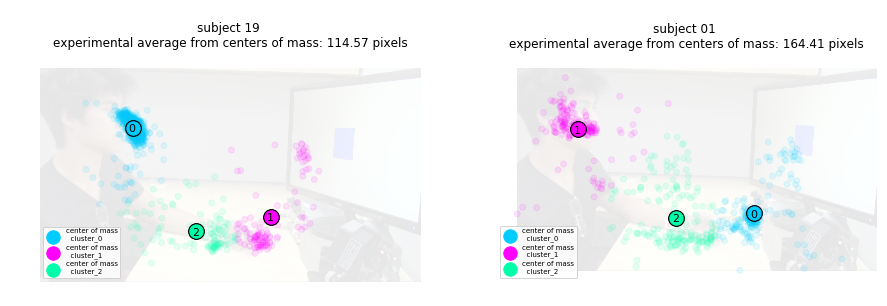

In [34]:
subjects = ['19', '01'] 
structured_data = generate_clusters(subjects, big_picture=1)

In [ ]:
subjects = ['04', '05'] 
structured_data = generate_clusters(subjects, big_picture=1)

In [ ]:
subjects = ['06', '07'] 
structured_data = generate_clusters(subjects, big_picture=1)

In [ ]:
subjects = ['08', '09'] 
structured_data = generate_clusters(subjects, big_picture=1)

In [ ]:
subjects = ['10', '18'] 
structured_data = generate_clusters(subjects, big_picture=1)

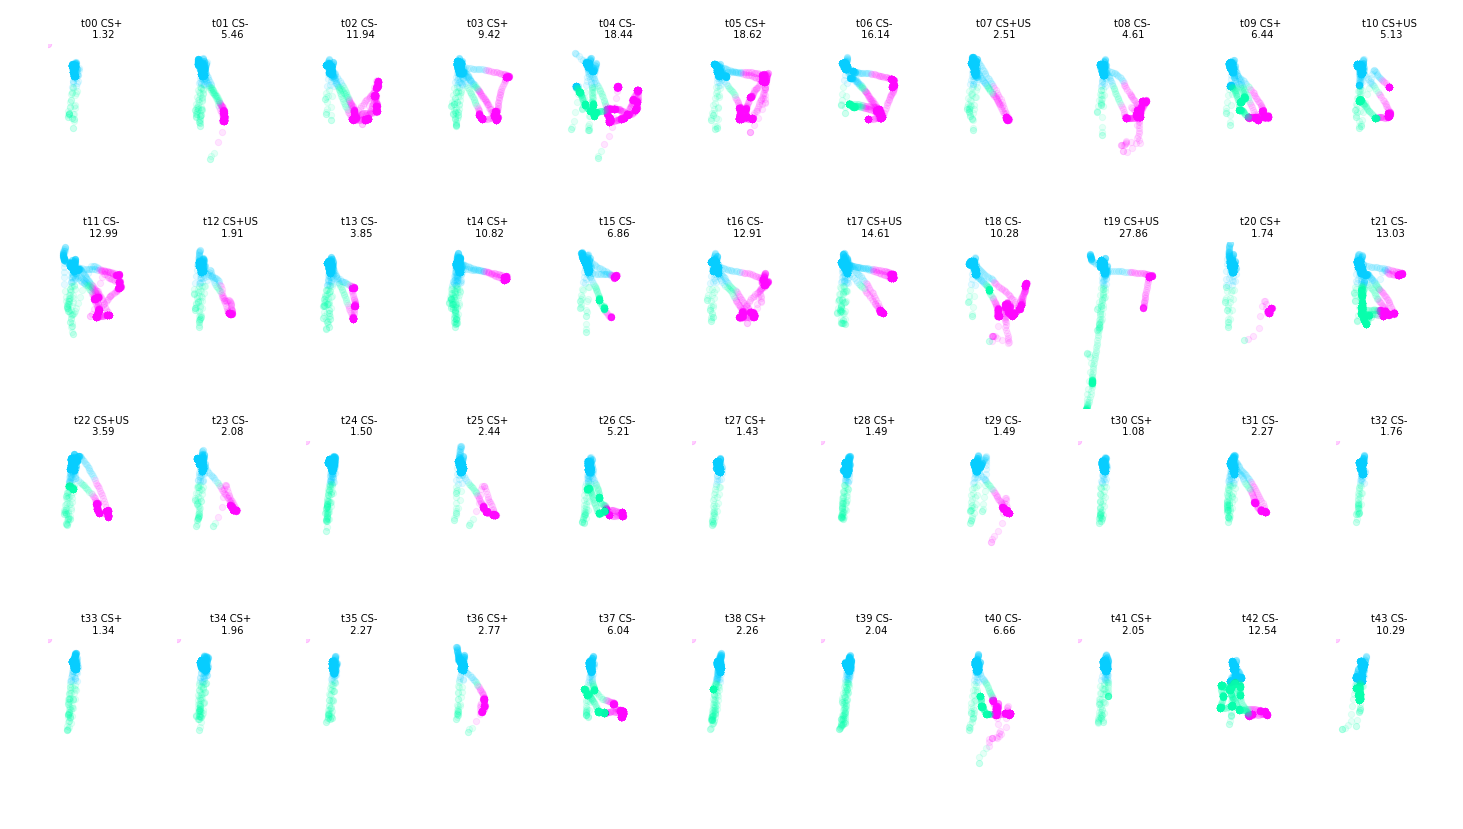

In [36]:
# get subject's data
subject_data = load_data(subjects[0])
data = extract_data(subject_data)

# generate clusters and find data to color mapping
k, xy = kmeans_coordinates(data['xy'], cut=0)
show = data['stimuli']['onsets']

# aesthetics
plt.figure(figsize=[25,14]);
colors = ['#00ccff', '#ff00ff', '#00ffaa']

for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    plt.axis('off')
    
    for i_lable in [0,1,2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_lable])**2))
        plt.scatter(gaze_clustered[:,0], -gaze_clustered[:,1], marker='o', s=40, alpha=.1, c =colors[i_lable]); 
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['stimuli']['cs_type'][ii], (np.sum(ss_cluster_difference)/10e6) ), fontsize=10)
    

```
average values from the centers of mass 

1) across the whole experiment can be an estimate of how much subjects were paying attention
    - e.g.'12' less focused than '08'because they're, for example, looking at the center of the screen more
2) can also be calculated within a single trial 
    - a measure how focused they were in a smaller time window
    - obvi some problems with this, but it's a start


alsoooooo subject '01' has a pretty different pattern of attention ... :) 

```
> a sketch of an anaysis for a **`type 2`** analysis is below

In [37]:
def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

In [38]:
# structured_data = generate_clusters(['18'], show=0)

# x_len, y_len = structured_data['image_dims']['x_len'], structured_data['image_dims']['y_len']

# e_sub = structured_data['18']
# data = e_sub['data'] 
# show = data['stimuli']['onsets']
# k =  e_sub['k']
# xy = e_sub['xy'] 

# gaze_exploration = [] 

# # aesthetics
# plt.figure(figsize=[25,14]); 
# for ii in range(len(show)-1): 
        
#     gaze_within = xy[show[ii]:show[ii+1]] 
#     lab_within = k.labels_[show[ii]:show[ii+1]]
#     ss_cluster_difference = np.zeros(3)
    
#     for i_lable in [0, 1, 2]:         
#         gaze_clustered = gaze_within[lab_within==i_lable]
#         if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
#         ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_lable])**2))

#     interval_exploration = np.sum(ss_cluster_difference)/10e6
#     plt.subplot(4,11,ii+1)
#     plt.xlim([0, 3000]), 
#     plt.ylim([-4000, 0])
#     plt.axis('off')
    
#     plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
#                 marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['stimuli']['cs_type'][ii])); 
    
    
#     plt.title('\nt%02d %s\n %.02f' 
#               %(ii, data['stimuli']['cs_type'][ii], interval_exploration ), fontsize=10)
    
#     gaze_exploration.append(interval_exploration) 

# gaze_exploration = np.array(gaze_exploration)

In [39]:
# plt.figure(figsize=[15,3])
# plt.plot(gaze_exploration, 'b', linewidth=4, alpha=.2)
# plt.plot(gaze_exploration, 'b', linewidth=14, alpha=.1)
# plt.xticks(range(0,len(gaze_exploration)), [data['stimuli']['cs_type'][ii][3:] for ii in range(len(data['stimuli']['cs_type']))], rotation=45); 
# plt.title("visual 'exploration' across the duration of the experiment\n (or 'distraction' or 'bordem' or 'looking at things other faces, wrists, and squares')\n")
# plt.ylabel('gaze time/distance away from clusters'); 

In [40]:
# from scipy import stats
# _ , p_val = stats.ttest_ind(gaze_exploration[6:22], gaze_exploration[22:])
# print("\n\nsignificant (p < %.02f) difference between conditioning and extinction in gaze 'exploration'?\n\n"%p_val)

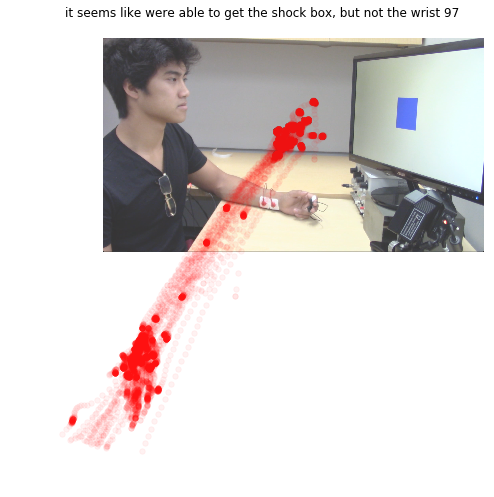

In [41]:
subjects, i_subject, day = ['97'], 0, 2
subject_data = load_data(subjects[i_subject], day=2)

data = extract_data(subject_data) 

plt.figure(figsize=[20,8]) ; plt.axis('off')
plt.imshow(model_image, alpha=.8)

# need to do some rescaling to format gaze data with arbitrary-size jpeg
plt.scatter(data['xy'][:,0], data['xy'][:,1],marker='o', s=30, alpha=.05, c = 'red')
plt.title('it seems like were able to get the shock box, but not the wrist %s\n'%subjects[i_subject]); 

In [42]:
tmp_difference = (k.cluster_centers_ - [300, 200])**2
difference = [sum(tmp_difference[ii,:]) for ii in range(len(tmp_difference))]
face_cluster = np.nonzero(difference == min(difference))[0]

In [43]:
i_label = face_cluster

interval_proportion = round(len(np.nonzero(k.labels_==i_label)[0])/len(k.labels_),2) 
gaze_clustered = xy[k.labels_==i_label]
ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_label])**2))
interval_exploration = round(np.sum(ss_cluster_difference)/10e6)

composite_attention2face = (1 / (1 - interval_proportion)) * interval_exploration

In [44]:
print('exploration: ', interval_exploration, 'proportion spent in region %s:'%i_label, interval_proportion) 

('exploration: ', 76.0, 'proportion spent in region [0]:', 0.0)


In [45]:
def show_centers(_center_, _color_, _alpha_=.1): 
    
    plt.scatter(_center_[0], _center_[1], s= 1000, color=_color_, alpha=_alpha_)
    plt.scatter(_center_[0], _center_[1], s= 2000, color=_color_, alpha=_alpha_)
    plt.scatter(_center_[0], _center_[1], s=10000, color=_color_, alpha=_alpha_)
    

In [46]:
subjects, i_subject = ['18', '01', '12', '05', '09', '11', '10'], 0
subject_data = load_data(subjects[i_subject], listen=1)
data = extract_data(subject_data)

('s18_d1.asc', '18')


In [47]:
n_fixations = len(data['fixation']['duration']) ; print 'totle number of fixations:',  n_fixations

totle number of fixations: 1481


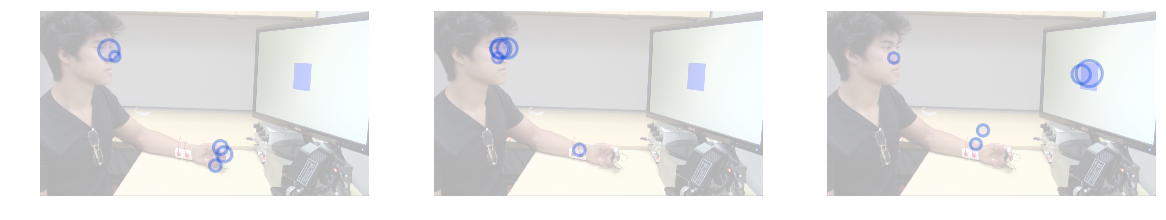

In [48]:
plt.figure(figsize=[20,15]) ; plt.axis('off')

n_images = 3
n_fixations = 5
for i_plot in range(n_images): 
        
    intervals = np.arange(500, 500 + n_fixations*n_images+1, n_fixations)
    int_i, int_j = intervals[i_plot], intervals[i_plot+1] 
    plt.subplot(1,3,i_plot+1)
    
    plt.imshow(model_image, alpha=.3)

    x_location = data['fixation']['xy'][int_i: int_j,0]
    y_location = data['fixation']['xy'][int_i: int_j,1]
    fix_duration = data['fixation']['duration'][int_i: int_j]

    alphas = fix_duration / int(max(fix_duration))
    alphas = np.array([round(alphas[ii],2) for ii in range(len(alphas))])
    alphas[alphas > .2] = .2


    # need to do some rescaling to format gaze data with arbitrary-size jpeg
    plt.scatter(x_location,y_location,
                marker='o', facecolors='blue', edgecolor='xkcd:blue', linewidth=3,  
                s=fix_duration, alpha=.05 )

    plt.scatter(x_location,y_location, 
                marker='o', facecolors='None', edgecolor='xkcd:blue', linewidth=3,  
                s=fix_duration, alpha=.3 )
    
    plt.axis('off')

    plt.xlim([0,x_len]) ; plt.ylim([y_len, 0])

In [49]:
from sklearn import metrics

('s18_d1.asc', '18')


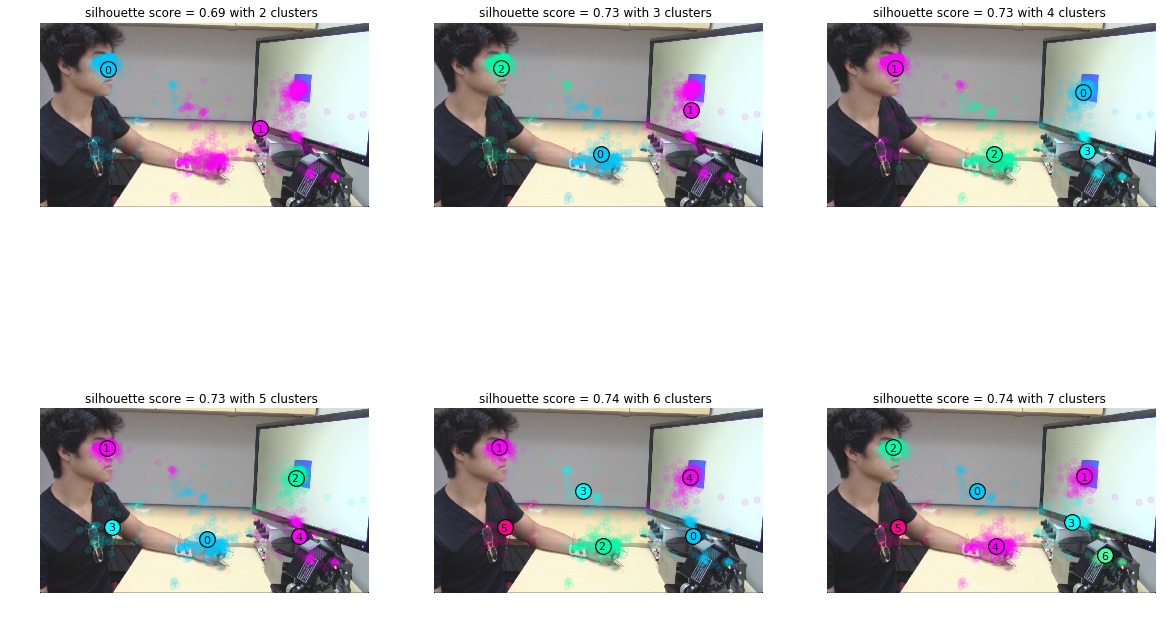

In [50]:
plt.figure(figsize=[20,13])
cluster_data = {}

# colors, shape
colors = ['#00ccff', '#ff00ff', '#00ffaa', 'cyan','magenta','#ff028d', '#53fca1'] #6600ff'] 
y_len, x_len, _ = np.shape(model_image)
cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}

subjects, i_subject = ['18', '01', '12', '05', '09', '11', '10'], 0
subject_data = load_data(subjects[i_subject], listen=1)
data = extract_data(subject_data)

clusters = [2,3,4,5,6,7]

for i_cluster in range(len(clusters)): 

    # generate clusters
    X = data['fixation']['xy']
    k, xy = kmeans_coordinates(X, n_clusters=clusters[i_cluster], cut=1)
    cluster_labels = k.fit_predict(xy)
    silhouette_avg = metrics.silhouette_score(xy, cluster_labels)

    # find data to color mapping
    point_colors = [colors[ii] for ii in k.labels_]
    # setup plot
    plt.subplot(2,3,i_cluster+1); plt.axis('off')
    # show background experimental stimuli
    plt.imshow(model_image, alpha=.9)
    # plot gaze data according to cluster color
    plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
    # extract centers of mass for each cluster
    centers = np.round(k.cluster_centers_)

    # plot center of mass for each cluster in a way we can clearly lable in legend
    for i_loc in range(len(centers)):
        plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
        plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                    s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
        plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                     xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

    plt.title("silhouette score = %.02f with %s clusters "  %(silhouette_avg, clusters[i_cluster]) )



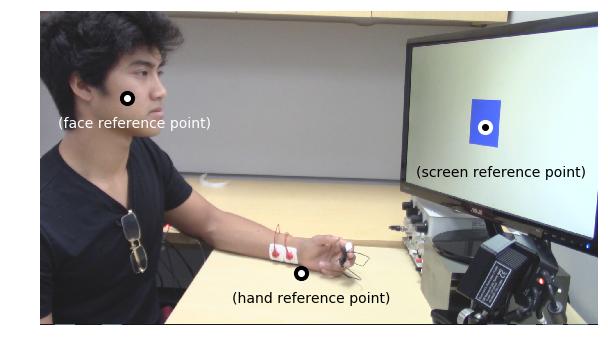

In [51]:
face_reference   = [300,  300]
hand_reference   = [900,  900]
square_reference = [1530, 400]

plt.figure(figsize=[10,8])
plt.imshow(model_image, alpha=.9) ; plt.axis('off')

plt.scatter(face_reference[0],face_reference[1], s=200, color='black')
plt.scatter(face_reference[0],face_reference[1], color='white')
plt.annotate('(face reference point)', xy=(face_reference[0],face_reference[1]), color='white', 
                             xytext=(-69, -30), textcoords='offset points', alpha=1, fontsize=14)

plt.scatter(hand_reference[0],hand_reference[1], s=200, color='black')
plt.scatter(hand_reference[0],hand_reference[1], color='white')
plt.annotate('(hand reference point)', xy=(hand_reference[0],hand_reference[1]), color='black', 
                             xytext=(-69, -30), textcoords='offset points', alpha=1, fontsize=14)

plt.scatter(square_reference[0],square_reference[1], s=200, color='white')
plt.scatter(square_reference[0],square_reference[1], color='black')
plt.annotate('(screen reference point)', xy=(square_reference[0],square_reference[1]), color='black', 
                             xytext=(-69, -50), textcoords='offset points', alpha=1, fontsize=14); 

In [58]:

# define reference points from image
reference_points = {'face':[300,  300], 'hand':[900, 900], 'square':[1550, 400]}
# define subjects to work with
subjects = ['19', '01', '12', '05', '09', '11', '10']
structured_data = generate_clusters(subjects, show=0)
# define radius to include around ROI center
include_radius = 300
roi_data = {}


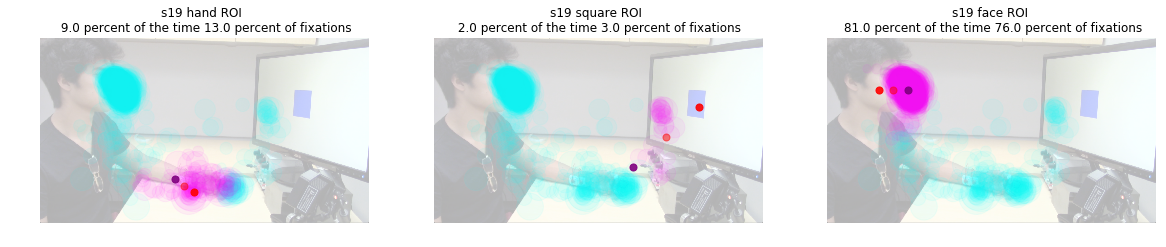

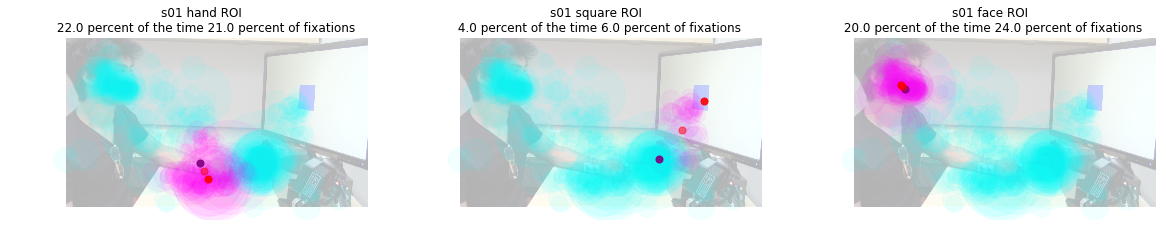

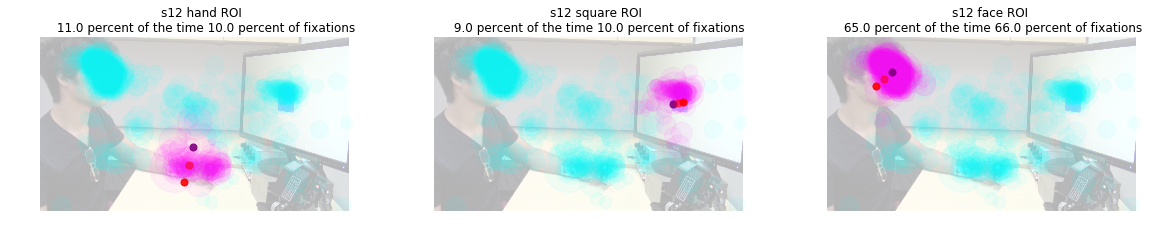

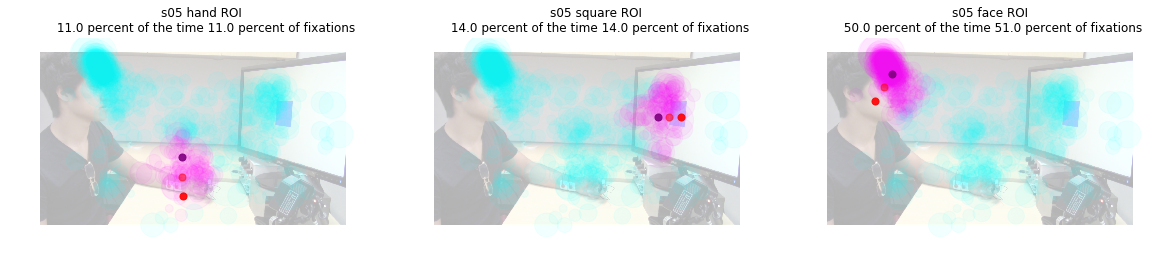

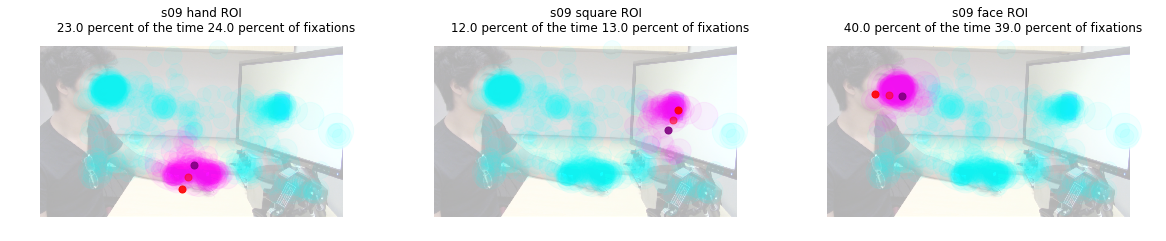

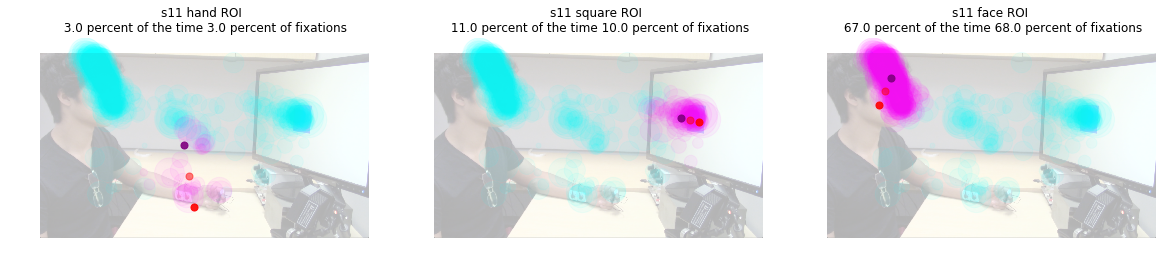

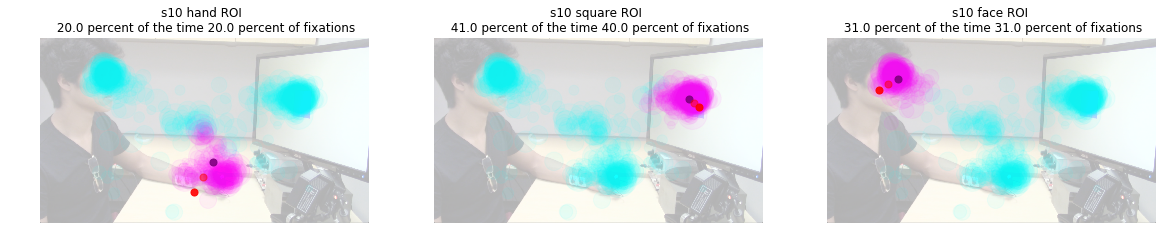

In [59]:
for i_subject in range(len(subjects)): 

    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
    duration = data['fixation']['duration']
    
    subject = subjects[i_subject]
    centers = structured_data[subject]['k'].cluster_centers_
    xy = structured_data[subject]['xy'] 

    plt.figure(figsize=[20,8]); i_plot = 1
    _roi_ = {} 
    for i_reference in reference_points.keys(): 
        
        # calculate
        i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
        center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
        distance_from = np.sum(abs(xy - center_of_mass),1)
        include = distance_from < include_radius
        percent_ROI = round(sum(duration[include])/ sum(duration) * 100)
        n_ROI = round(len(duration[include])/ float(len(duration)) * 100)
        
        # save 
        _roi_[i_reference] = percent_ROI
        
        # show
        plt.subplot(1,3,i_plot); i_plot += 1 
        plt.imshow(model_image, alpha=.3) ; plt.axis('off')
        plt.scatter(xy[:,0], xy[:,1], c=include, s=data['fixation']['duration'], alpha=.05, cmap='cool', label='fixations')    
        plt.scatter(centers[i_center,0], centers[i_center,1], color='purple', s=50, alpha=.9, label='cluster COM')
        plt.scatter(reference_points[i_reference][0], reference_points[i_reference][1], color='red', s=50, alpha=.9, label='image reference')
        plt.scatter(center_of_mass[0], center_of_mass[1], color='red', s=50, alpha=.5, label='halfway')
        #plt.legend(fontsize=8)
        plt.title('s%s %s ROI \n %s percent of the time %s percent of fixations'%(subjects[i_subject], i_reference, percent_ROI, n_ROI))
    
    roi_data[subject] = _roi_ 
        

In [54]:
roi_data

{'01': {'face': 20.0, 'hand': 22.0, 'square': 4.0},
 '05': {'face': 50.0, 'hand': 11.0, 'square': 14.0},
 '09': {'face': 40.0, 'hand': 23.0, 'square': 12.0},
 '10': {'face': 31.0, 'hand': 20.0, 'square': 41.0},
 '11': {'face': 67.0, 'hand': 3.0, 'square': 11.0},
 '12': {'face': 65.0, 'hand': 11.0, 'square': 9.0},
 '18': {'face': 37.0, 'hand': 19.0, 'square': 29.0}}

In [55]:
import scipy.ndimage as ndimage

In [56]:
subject = '08'
subject_data = load_data(subject, listen=1)
data = extract_data(subject_data)
xy = data['fixation']['xy']
duration = data['fixation']['duration']

('s08_d1.asc', '08')


In [57]:
y_lim, x_lim = np.shape(model_image)[0], np.shape(model_image)[1]
slate = np.zeros([y_lim, x_lim])
for ii in range(len(xy)): 
    if xy[ii,0] < x_lim and xy[ii,1] < y_lim: 
        slate[xy[ii,1], xy[ii,0]] = duration[ii]

In [ ]:
plt.figure(figsize=[15,6])
plt.imshow(model_image)
heatmap = ndimage.gaussian_filter(slate, sigma=(20, 20), order=0)
plt.imshow(heatmap, cmap='PuRd', alpha=.6) # or plasma or pink or PuRd
plt.clim([0,heatmap.max()/50]) ; plt.axis('off')

In [ ]:
def roi_percent_analysis(subjects, show=0): 
    
    structured_data = generate_clusters(subjects, show=0)
    
    for i_subject in range(len(subjects)): 
        
        subject = subjects[i_subject]
        centers = structured_data[subject]['k'].cluster_centers_
        duration = structured_data[subject]['data']['fixation']['duration']
        xy = structured_data[subject]['xy'] 

        _roi_ = {} 

        if show: plt.figure(figsize=[20,8]); i_plot = 1

        for i_reference in reference_points.keys(): 

            # calculate
            i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
            center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
            distance_from = np.sum(abs(xy - center_of_mass),1)
            include = distance_from < include_radius
            percent_ROI = round(sum(duration[include])/ sum(duration) * 100)
            n_ROI = round(len(duration[include])/ float(len(duration)) * 100)

            # save 
            _roi_[i_reference] = percent_ROI

            if show: 
                plt.subplot(1,3,i_plot); i_plot += 1 
                plt.imshow(model_image, alpha=.3) ; plt.axis('off')
                plt.scatter(xy[:,0], xy[:,1], c=include, s=data['fixation']['duration'], alpha=.05, cmap='cool', label='fixations')    
                plt.scatter(centers[i_center,0], centers[i_center,1], color='purple', s=50, alpha=.9, label='cluster COM')
                plt.scatter(reference_points[i_reference][0], reference_points[i_reference][1], color='red', s=50, alpha=.9, label='image reference')
                plt.scatter(center_of_mass[0], center_of_mass[1], color='red', s=50, alpha=.5, label='halfway')
                #plt.legend(fontsize=8)
                plt.title('s%s %s ROI \n %s percent of the time %s percent of fixations'%(subjects[i_subject], i_reference, percent_ROI, n_ROI))

        roi_data[subject] = _roi_ 
    
    return roi_data

In [ ]:
type(subjects[0])

In [ ]:
#subjects = [int(ii) for ii in range(16,20)]
subjects = ['12']
roi_data = roi_percent_analysis(subjects) ; roi_data

In [ ]:
def extract_time_info(subject_data): 
    
    CS_on = []
    CS_off = [] 
    US = []
    US_count = 0 
    CS_count = 0
    cs_type = [] 
    ref_count = 0
    reinforcement = []
    
    
    for ii in range(len(subject_data)): 
        msg = subject_data[ii] 

        if len(msg): 
            if msg[0] == "MSG" and "VFRAME" not in msg[1]: 
                
                if 'ONSET' in msg[1] and 'TRIAL' in msg[1]: 
                    CS_on.append([CS_count, msg[1][:str.find(msg[1], ' ')], msg[1]])
                    reinforcement.append(0)
                    

                if 'OFFSET' in msg[1] and 'TRIAL' in msg[1]: 
                    CS_off.append([CS_count, msg[1][:str.find(msg[1], ' ')], msg[1]])
                    CS_count += 1 
                
                if 'US' in msg[1]: 
                    US.append([US_count, msg[1][:str.find(msg[1], ' ')], msg])
                    US_count += 1 
                    
                    del reinforcement[-1]; reinforcement.append(1)
    
    return US, CS_on, CS_off, np.array(reinforcement)

In [ ]:
def show_gaze_stimuli(stim, sample_rate, time):
    # find sample rate be second
    gaze_behavior = []
    figure(figsize=[15,5])
    for i in range(len(stim)): 
        
        # let's find the first US 
        us = int(stim[i][1])
        # define the end of the interval to look over
        n_seconds = 1
        end_interval = us + sample_rate * n_seconds

        # find indices for time we're interested in 
        i_behavior = (time < end_interval) & (time > us)
        
        subplot(2,3,i+1)
        imshow(model_image,alpha=1)
        scatter(data['xy'][:,0][i_behavior], data['xy'][:,1][i_behavior],c=range(len(np.nonzero(i_behavior)[0])), 
               #s=data['fixation']['duration'], 
                marker='o',
                cmap="Blues", alpha=.5)
        ylim(1000,0)
        axis('off')

In [ ]:

subjects, i_subject = ['24'], 0
subject_data = load_data(subjects[i_subject])
data = extract_data(subject_data) 
US, CS_on, CS_off, reinforcement = extract_time_info(subject_data)
sample_rate = (int(CS_off[0][1]) - int(CS_on[0][1]))/4
time = np.array(data['xy_time'])
show_gaze_stimuli(US, sample_rate, time)


In [ ]:
reference_points = {'face':[300,  300], 'wrist':[900, 900], 'stim':[1550, 400]}
reference_names = reference_points.keys()
include_radius = 200

In [ ]:
subjects, i_subject = ['19'], 0
subject_data = load_data(subjects[i_subject])
data = extract_data(subject_data) 
US, CS_on, CS_off, reinforcement = extract_time_info(subject_data)

structured_data = generate_clusters(data, show=0)
centers = structured_data['k'].cluster_centers_

time = data['xy_time']
xy = data['xy'] 

In [ ]:

roi_data= {'face':[], 'wrist':[], 'stim':[], 'type':[]}
stimulus = CS_on

for i in range(len(CS_on)): 
    
    stim = int(stimulus[i][1])
    # define the end of the interval to look over
    end_interval = int(CS_off[i][1])#stim + sample_rate * n_seconds
        
    # find indices for time we're interested in
    i_behavior = (time < end_interval) & (time > stim)

    # extract indices from whole timecourse
    i_xy = data['xy'][i_behavior]
    roi_data['type'].append(CS_on[i][2][-3:])
    
    show = 0
    if show: plt.figure(figsize=[20,8]); i_plot = 1
    
    for i_reference in reference_points.keys(): 

        # calculate
        i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
        center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
        distance_from = np.sum(abs(i_xy - center_of_mass),1)
        include = distance_from < include_radius
        percent_ROI = (100* sum(include) / float(len(i_xy)))        
        roi_data[i_reference].append(percent_ROI)

        if show: 
            plt.subplot(1,3,i_plot); i_plot += 1 
            plt.imshow(model_image, alpha=.3) ; plt.axis('off')
            plt.scatter(i_xy[:,0], i_xy[:,1], c = include + 1, alpha=.5, cmap='cool', label='gaze')    
            plt.legend([CS_on[i][2][-3:]], fontsize=15)
            plt.title('s%s %s ROI \n %s percent of the time percent of fixations'%(subjects[i_subject], i_reference, percent_ROI))
            
            

roi_data['face'] = np.array(roi_data['face'])
roi_data['stim'] = np.array(roi_data['stim'])
roi_data['wrist'] = np.array(roi_data['wrist'])
            
n_seconds = 1
stimulus = US
US_gaze_patterns = {'face':[], 'wrist':[], 'stim':[]}

for i in range(len(stimulus)): 
    
    stim = int(stimulus[i][1])
    # define the end of the interval to look over
    end_interval = stim + sample_rate * n_seconds
        
    # find indices for time we're interested in
    i_behavior = (time < end_interval) & (time > stim)

    # extract indices from whole timecourse
    i_xy = data['xy'][i_behavior]
    
    show = 0
    if show: plt.figure(figsize=[20,8]); i_plot = 1
    
    for i_reference in reference_points.keys(): 

        # calculate
        i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
        center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
        distance_from = np.sum(abs(i_xy - center_of_mass),1)
        include = distance_from < include_radius
        percent_ROI = (100* sum(include) / float(len(i_xy)))        
        if percent_ROI == percent_ROI: 
            US_gaze_patterns[i_reference].append(percent_ROI)
        else: 
            US_gaze_patterns[i_reference].append(0)

        if show: 
            plt.subplot(1,3,i_plot); i_plot += 1 
            plt.imshow(model_image, alpha=.3) ; plt.axis('off')
            plt.scatter(i_xy[:,0], i_xy[:,1], c = include + 1, alpha=.5, cmap='cool', label='gaze')    
            plt.title('s%s %s ROI \n %s percent of the time percent of fixations'%(subjects[i_subject], i_reference, percent_ROI))


US_gaze_patterns['face'] = np.array(US_gaze_patterns['face'])
US_gaze_patterns['stim'] = np.array(US_gaze_patterns['stim'])
US_gaze_patterns['wrist'] = np.array(US_gaze_patterns['wrist'])

In [ ]:
print('face: %2d, wrist: %2d, screen: %d'%(mean(US_gaze_patterns['face']), mean(US_gaze_patterns['wrist']), mean(US_gaze_patterns['stim']))) 

In [ ]:
sum([mean(US_gaze_patterns[ii]) for ii in US_gaze_patterns.keys()])

In [ ]:
print('face: %2d, wrist: %2d, screen: %d'%(mean(roi_data['face'][non_reinforced]), mean(roi_data['wrist'][non_reinforced]), mean(roi_data['stim'][non_reinforced]))) 

In [ ]:
sum([mean(roi_data[ii]) for ii in US_gaze_patterns.keys()]) # last keys() is not an error

In [ ]:
#
#  SHOCK     !=    NO SHOCK
#  
# F
# \          !-         S 
#  \         !-  F     /
#   \  S          \   /
#    W/            \W/ 
#
# attentional mean is higher in shock + F and S are switched
#

In [ ]:
import scipy.stats as stats

In [ ]:
a,b,c = mean(US_gaze_patterns['face']), mean(US_gaze_patterns['wrist']), mean(US_gaze_patterns['stim'])

In [ ]:
A,B,C = mean(roi_data['face'][non_reinforced]), mean(roi_data['wrist'][non_reinforced]), mean(roi_data['stim'][non_reinforced])

In [ ]:
bootstrap = []

for i in range(10000): 

    a = mean(np.random.choice(US_gaze_patterns['face'], 6)) 
    b = mean(np.random.choice(US_gaze_patterns['wrist'],6))
    c = mean(np.random.choice(US_gaze_patterns['stim'],6))
    chi, p = stats.chisquare(f_obs= np.array([a,b,c]),   # Array of observed counts
                    f_exp= np.array([A,B,C]))
    
    bootstrap.append(p)
    

In [ ]:
results.append(mean(bootstrap))

In [ ]:
mean(bootstrap)

In [ ]:
mean(results)

In [ ]:
#results = [] 

In [ ]:
scatter(np.ones(len(non_reinforced))-1.5, roi_data['face'][non_reinforced],alpha=.3, color='blue') 
scatter(np.ones(len(non_reinforced))-.5, roi_data['wrist'][non_reinforced],alpha=.3, color='blue') 
scatter(np.ones(len(non_reinforced))+.5, roi_data['stim'][non_reinforced],alpha=.3, color='blue') 
scatter(np.ones(len(US_gaze_patterns['face']))-1, US_gaze_patterns['face'],alpha=.3, color='red') 
scatter(np.ones(len(US_gaze_patterns['face'])),   US_gaze_patterns['wrist'],alpha=.3, color='red') 
scatter(np.ones(len(US_gaze_patterns['face']))+1, US_gaze_patterns['stim'],alpha=.3, color='red') 

In [ ]:
 
def structured_gaze_analysis(stimulus_type, stimulus_data, time, xy, centers, include_radius):
    
    # set up data structures
    roi_data= {'face':[], 'wrist':[], 'stim':[], 'sum':[]}    
    
    # specific options for CS or US 
    if stimulus_type == 'CS': 
        roi_data['type'] = []
        n_stimuli = len(stimulus_data[0])
    if stimulus_type == 'US': 
        n_seconds  = 1
        n_stimuli = len(stimulus_data)
    if stimulus_type == 'offsets': 
        n_seconds  = 1
        n_stimuli = len(stimulus_data)
        
    # define ROI centers on reference image 
    reference_points = {'face' :[300,  300], 
                        'wrist':[900,  900], 
                        'stim' :[1550, 400]}

    for i in range(n_stimuli): 

        # define the end of the interval to look over
        if stimulus_type == 'CS': 
            onset = stimulus_data[0]
            offset = stimulus_data[1]
            
            stim = int(onset[i][1])
            end_interval = int(offset[i][1])
            roi_data['type'].append(onset[i][2][-3:])
            
        if stimulus_type == 'US': 
            stim = int(stimulus_data[i][1]) + sample_rate * 1
            end_interval = stim + sample_rate * n_seconds
        
        if stimulus_type == 'offsets': 
            stim = int(stimulus_data[i][1]) + sample_rate * 1
            end_interval = stim + sample_rate * n_seconds
        
        # find indices for time we're interested in
        i_behavior = (time < end_interval) & (time > stim)

        # extract indices from whole timecourse
        i_xy =xy[i_behavior]
        
        stim_sum = []
        for i_reference in reference_points.keys(): 

            # find which cluster-based center is closest  to the image-based center
            i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
            # 
            center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
            distance_from = np.sum(abs(i_xy - center_of_mass),1)
            include = distance_from < include_radius
            percent_ROI = (100* sum(include) / float(len(i_xy))) 
            if percent_ROI != percent_ROI: 
                percent_ROI = 0
            
            roi_data[i_reference].append(percent_ROI)
            stim_sum.append(percent_ROI)
            
        roi_data['sum'].append(sum(stim_sum))

    roi_data['face']  = np.array(roi_data['face'])
    roi_data['wrist'] = np.array(roi_data['wrist'])
    roi_data['stim']  = np.array(roi_data['stim'])
    roi_data['sum']   = np.array(roi_data['sum'])
    
    return roi_data
 

In [ ]:
roi_analysis = structured_gaze_analysis('CS', [CS_on, CS_off], time, xy, centers, include_radius)

In [ ]:

# use any trial with nans as an ignore trial. count ignore trials across participants. 

###########
########### use sum of averages as a measure of attention
###########


In [ ]:
def get_subject_names(day= 1, listen=0): 

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(int(file[1:3]))

    return data_file_names[18:-2]


In [ ]:
get_subject_names()

In [ ]:
def generate_clusters(data, show=1, cut=1, big_picture=0): # zzzz
    
    cluster_data = {}
    
    # colors, shape
    colors = ['#00ccff', '#ff00ff', '#00ffaa'] #6600ff'] 
    y_len, x_len, _ = np.shape(model_image)
    cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}
    
    if show: plt.figure(figsize=[15, 12])

    # generate clusters
    k, xy = kmeans_coordinates(data['fixation']['xy'], cut)

    # save 
    cluster_data = {'data':data, 'k':k, 'xy':xy}

    if show: 

        # find data to color mapping
        point_colors = [colors[ii] for ii in k.labels_]
        # setup plot
        plt.subplot(1,2,i_subject+1); plt.axis('off')
        # show background experimental stimuli
        plt.imshow(model_image, alpha=.1)
        # plot gaze data according to cluster color
        plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
        # extract centers of mass for each cluster
        centers = np.round(k.cluster_centers_)

        # plot center of mass for each cluster in a way we can clearly lable in legend
        for i_loc in range(len(centers)):
            plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
            plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                        s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
            plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                         xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

        # control aesthetics
        if not big_picture: 
            plt.xlim([0, x_len]), 
            plt.ylim([y_len, 0])
        plt.legend(); ax = plt.gca(); ax.legend(fontsize = 6+1, loc=3)
        plt.title("\nexperimental average from centers of mass: %.02f pixels\n" 
                  %(np.sqrt(k.inertia_/len(xy)) ) )

    
    return cluster_data

In [ ]:
gaze_CS, gaze_US = {}, {} 
subjects = get_subject_names()

for i_subject in range(len(subjects)): 
    """Run analysis to get distributions of attention over 3 areas of interest"""
    # load edf (asc) file
    subject_data = load_data(subjects[i_subject])
    # extract relevent information
    data = extract_data(subject_data)  ; 
    # identify CS and US timing withing gaze data # zzzz
    US, CS_on, CS_off, reinforcement = extract_time_info(subject_data)
    # generate clusters 
    structured_data = generate_clusters(data, show=0)
    # extract centers of each cluster
    centers = structured_data['k'].cluster_centers_
    # get time and location info
    time = data['xy_time']    
    xy = data['xy'] 
    # run analysis to get percent of time for each ROI 
    gaze_US[subjects[i_subject]] = structured_gaze_analysis('US',        US      , time, xy, centers, include_radius)
    gaze_CS[subjects[i_subject]] = structured_gaze_analysis('CS', [CS_on, CS_off], time, xy, centers, include_radius)
    

In [ ]:
face_cs = np.array([gaze_CS[ii]['face'] for ii in subjects]).flatten()
wrist_cs = np.array([gaze_CS[ii]['wrist'] for ii in subjects]).flatten()
stim_cs = np.array([gaze_CS[ii]['stim'] for ii in subjects]).flatten()

face_us = np.array([gaze_US[ii]['face'] for ii in subjects]).flatten()
wrist_us = np.array([gaze_US[ii]['wrist'] for ii in subjects]).flatten()
stim_us = np.array([gaze_US[ii]['stim'] for ii in subjects]).flatten()

In [ ]:
figure(figsize=[8,5])
np.random.randn(len(face_cs))
scatter(np.zeros(len(face_cs)) -1 + np.random.randn(len(face_cs))/50, face_cs.flatten(), alpha=.05, color='xkcd:blue')
scatter(np.zeros(len(wrist_cs))+0 + np.random.randn(len(wrist_cs))/50, wrist_cs.flatten(), alpha=.05, color='xkcd:red')
scatter(np.zeros(len(stim_cs)) +1 + np.random.randn(len(stim_cs))/50, stim_cs.flatten(), alpha=.05, color='xkcd:purple')
#scatter([-1,0,1], [np.mean(face_cs),np.mean(wrist_cs), np.mean(stim_cs)],s=500, 
#        alpha=.8, color=['blue', 'red', 'purple'], marker='_', linewidth=5)

scatter([-1,0,1], [np.mean(face_cs),np.mean(wrist_cs), np.mean(stim_cs)],s=2000, 
         alpha=.2, color=['xkcd:blue', 'xkcd:red', 'xkcd:purple'], marker='_', linewidth=5)


scatter(np.zeros(len(face_us)) -1.5 + np.random.randn(len(face_us))/50, face_us, alpha=.1, color='xkcd:blue')
scatter(np.zeros(len(wrist_us))-0.5 + np.random.randn(len(wrist_us))/50, wrist_us, alpha=.1, color='xkcd:red')
scatter(np.zeros(len(stim_us)) +0.5 + np.random.randn(len(stim_us))/50, stim_us, alpha=.1, color='xkcd:purple')
#scatter([-1.3,-0.3,0.7], [np.mean(face_us),np.mean(wrist_us), np.mean(stim_us)],s=500, 
#        alpha=.8, color=['xkcd:blue', 'xkcd:red', 'xkcd:purple'], marker='_', linewidth=5); 
scatter([-1.5,-0.5,0.5], [np.mean(face_us),np.mean(wrist_us), np.mean(stim_us)],s=2000, 
        alpha=.2, color=['xkcd:blue', 'xkcd:red', 'xkcd:purple'], marker='_', linewidth=5); 

xticks(np.array([-1.5, -1, -.5, 0, 0.5 ,1 ])-.1, 
       ['face(US)', 'face (CS)', 'wrist (US)', 'wrist (CS)', 'screen (US)', 'screen (CS)'], rotation=45)

yticks([0, 50, 100])
ylim(-10,120)
ylabel('percent of time looking'); 
title('distribution of look time at AOIs during stimulus related events\n'); 

In [ ]:
bootstrap = []

A, B, C = mean(face_us), mean(wrist_us), mean(stim_us)

for i in range(1000): 

    a = mean(np.random.choice(face_cs,  6)) 
    b = mean(np.random.choice(wrist_cs, 6))
    c = mean(np.random.choice(stim_cs,  6))
    chi, p = stats.chisquare(f_obs= np.array([a,b,c]),   # Array of observed counts
                    f_exp= np.array([A,B,C]))    
    bootstrap.append(p)

mean(bootstrap)

In [ ]:
stats.ttest_ind(face_cs, face_us)

In [21]:
stats.ttest_ind(wrist_cs, wrist_us)

NameError: name 'stats' is not defined

In [22]:
stats.ttest_ind(stim_cs, stim_us)

NameError: name 'stats' is not defined

In [23]:
CS_pos = np.array(['CS+' in data['stimuli']['cs_type'][ii] for ii in range(len(data['stimuli']['cs_type']))])
CS_neg = np.array(['CS-' in data['stimuli']['cs_type'][ii] for ii in range(len(data['stimuli']['cs_type']))])

In [24]:
face_pos = [gaze_CS[ii]['face'] for ii in subjects]
face_pos = np.array([face_pos[ii][CS_pos] for ii in range(len(subjects))]).flatten()
wrist_pos = [gaze_CS[ii]['wrist'] for ii in subjects]
wrist_pos = np.array([wrist_pos[ii][CS_pos] for ii in range(len(subjects))]).flatten()
stim_pos = [gaze_CS[ii]['stim'] for ii in subjects]
stim_pos = np.array([stim_pos[ii][CS_pos] for ii in range(len(subjects))]).flatten()

face_neg = [gaze_CS[ii]['face'] for ii in subjects]
face_neg = np.array([face_neg[ii][CS_neg] for ii in range(len(subjects))]).flatten()
wrist_neg = [gaze_CS[ii]['wrist'] for ii in subjects]
wrist_neg = np.array([wrist_neg[ii][CS_neg] for ii in range(len(subjects))]).flatten()
stim_neg = [gaze_CS[ii]['stim'] for ii in subjects]
stim_neg = np.array([stim_neg[ii][CS_neg] for ii in range(len(subjects))]).flatten()

NameError: name 'gaze_CS' is not defined

In [25]:
def show_gaze_distribution(distributions, colors, scaled=.3): 
    
    figure(figsize=[8,5])
    for i_dist in range(len(distributions)): 
        a, b, c = distributions[i_dist][0], distributions[i_dist][1], distributions[i_dist][2]
        np.random.randn(len(a))
        scatter(np.zeros(len(a)) -1 + np.random.randn(len(a))/50 + scaled[i_dist], a.flatten(), 
                alpha=.05, color=colors[i_dist][0])
        scatter(np.zeros(len(b))+0 + np.random.randn(len(b))/50 + scaled[i_dist], b.flatten(), 
                alpha=.05, color=colors[i_dist][1])
        scatter(np.zeros(len(c)) +1 + np.random.randn(len(c))/50 + scaled[i_dist], c.flatten(), 
                alpha=.05, color=colors[i_dist][2])
        scatter(np.array([-1,0,1]) + scaled[i_dist], [np.mean(a),np.mean(b), np.mean(c)],s=500, 
                alpha=.8, color=colors[i_dist], marker='_', linewidth=5)
    xticks(np.array([-1+max(scaled), -1, 0,(max(scaled)),1, 1 +  (max(scaled)) ])-.1, 
       ['face(CS+)', 'face (CS-)', 'wrist (CS+)', 'wrist (CS-)', 'screen (CS+)', 'screen (CS-)'], rotation=45)


In [26]:
gaze_distributions = [[face_neg, wrist_neg, stim_neg], [face_pos, wrist_pos, stim_pos]]
colors = [['blue', 'blue', 'blue'], ['red', 'red','red']]
show_gaze_distribution(gaze_distributions, colors, scaled = np.array([0,.3]))
plt.title('no difference between percent in AOIs during CS+ and CS-\n')

NameError: name 'face_neg' is not defined

In [ ]:
[hist(gaze_CS[ii]['sum'][CS_neg],alpha=.1,color='blueviolet', bins=9) for ii in subjects]; 
[hist(gaze_CS[ii]['sum'][CS_pos],alpha=.1,color='red', bins=9) for ii in subjects]; 
title('\ndistribution of attention to AOIs across experiment for all subjects\n'); 

In [ ]:
hist([mean(gaze_CS[ii]['sum'])  for ii in subjects], alpha=.4)
xlim(0,100)
xlabel('\npercent of time in AOIs')
ylabel('count')
yticks([1,2,3], [1,2,3])
xticks([0, 50,100],['\n0', '\n50', '\n100'])
title('average attention across experiment for each subject\n'); 

In [ ]:
# this is imperfect because it penalizes people for switching where they're looking ... how to capture this? 

In [ ]:
attending = [mean(gaze_CS[ii]['sum'])  for ii in subjects]
shocking = [mean(gaze_US[ii]['sum'])  for ii in subjects]

In [ ]:
i_jitter = np.random.randn(len(attending))/50
j_jitter = np.random.randn(len(shocking))/50
scatter(np.ones(len(attending))+i_jitter, attending, alpha=.4)
scatter(np.zeros(len(shocking))+j_jitter, shocking, alpha=.4)
xlim(-1,2)
ylim(0,100)

In [ ]:
gaze_offsets = {} 
subjects = get_subject_names()

for i_subject in range(len(subjects)): 
    """Run analysis to get distributions of attention over 3 areas of interest"""
    # load edf (asc) file
    subject_data = load_data(subjects[i_subject])
    # extract relevent information
    data = extract_data(subject_data)  ; 
    # identify CS and US timing withing gaze data # zzzz
    US, CS_on, CS_off, reinforcement = extract_time_info(subject_data)
    # generate clusters 
    structured_data = generate_clusters(data, show=0)
    # extract centers of each cluster
    centers = structured_data['k'].cluster_centers_
    # get time and location info
    time = data['xy_time']    
    xy = data['xy'] 
    # run analysis to get percent of time for each ROI 
    gaze_offsets[subjects[i_subject]] = structured_gaze_analysis('offsets', CS_off, time, xy, centers, include_radius)

In [ ]:
_type_ = 'sum'
offset_regular = np.array([gaze_offsets[ii][_type_]  for ii in subjects]).flatten()
shocking = np.array([gaze_US[ii][_type_]  for ii in subjects]).flatten()

In [ ]:
US_present = np.array(['US' in data['stimuli']['cs_type'][ii] for ii in range(len(data['stimuli']['cs_type']))])

In [ ]:
i_jitter = np.random.randn(len(offset_regular))/50
j_jitter = np.random.randn(len(shocking))/50
scatter(np.ones(len(offset_regular))+i_jitter, offset_regular, alpha=.05, label='no US offsets')
scatter(np.zeros(len(shocking))+j_jitter, shocking, alpha=.4, label='US offsets')
xlim(-1,2)
ylim(0,100)
legend()

In [ ]:
face_pos_off = [gaze_offsets[ii]['face'] for ii in subjects]
face_pos_off = np.array([face_pos_off[ii][CS_pos] for ii in range(len(subjects))]).flatten()
wrist_pos_off = [gaze_offsets[ii]['wrist'] for ii in subjects]
wrist_pos_off = np.array([wrist_pos_off[ii][CS_pos] for ii in range(len(subjects))]).flatten()
stim_pos_off = [gaze_offsets[ii]['stim'] for ii in subjects]
stim_pos_off = np.array([stim_pos_off[ii][CS_pos] for ii in range(len(subjects))]).flatten()

face_neg_off = [gaze_offsets[ii]['face'] for ii in subjects]
face_neg_off = np.array([face_neg_off[ii][CS_neg] for ii in range(len(subjects))]).flatten()
wrist_neg_off = [gaze_offsets[ii]['wrist'] for ii in subjects]
wrist_neg_off = np.array([wrist_neg_off[ii][CS_neg] for ii in range(len(subjects))]).flatten()
stim_neg_off = [gaze_offsets[ii]['stim'] for ii in subjects]
stim_neg_off = np.array([stim_neg_off[ii][CS_neg] for ii in range(len(subjects))]).flatten()

In [ ]:
gaze_distributions = [[face_neg_off, wrist_neg_off, stim_neg_off], [face_pos_off, wrist_pos_off, stim_pos_off]]
colors = [['blue', 'blue', 'blue'], ['red', 'red','red']]
show_gaze_distribution(gaze_distributions, colors, scaled = np.array([0,.3]))
plt.title('difference between percent in AOIs during CS+ and CS- at offsets\n'); 

In [ ]:
tmp_face = [gaze_offsets[ii]['face'] for ii in subjects]
tmp_wrist = [gaze_offsets[ii]['wrist'] for ii in subjects]
tmp_stim = [gaze_offsets[ii]['stim'] for ii in subjects]

In [ ]:
a, b, c, d = np.zeros(len(tmp_face[0])*3), np.zeros(len(tmp_face[0])*3), np.zeros(len(tmp_face[0])*3), np.zeros(len(tmp_face[0])*3) 
a[0::3] = 1 
b[1::3] = 1
c[2::3] = 1

In [ ]:
d[a == 1] = tmp_face
d[b == 1] = tmp_wrist
d[c == 1] = tmp_stim

In [ ]:
figure(figsize=[8,5])
sub = 1  ; stim= 10
for stim in range(len(tmp_stim[0])): 
    [plot([1,2,3],
          np.array([tmp_face[sub][stim], tmp_wrist[sub][stim], tmp_stim[sub][stim]]), alpha=.3, 
          linewidth=3) 
     for sub in range(len(tmp_face))];
    [scatter([1,2,3],
          np.array([tmp_face[sub][stim], tmp_wrist[sub][stim], tmp_stim[sub][stim]]), alpha=.005, 
          linewidth=3, marker=',') 
     for sub in range(len(tmp_face))]
